#  Weather Image Recognition
- https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'yuaram1'
os.environ['KAGGLE_KEY'] = '0f1479af8e0608c1f4310440624b82a1'

In [3]:
!kaggle datasets download -d jehanbhathena/weather-dataset

 98% 575M/587M [00:04<00:00, 195MB/s]
100% 587M/587M [00:04<00:00, 134MB/s]


In [4]:
!unzip -q weather-dataset.zip

# train,  validation 나누기

In [5]:
import random
import shutil

def split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2):
    # 클래스 폴더 목록 가져오기
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        validation_class_path = os.path.join(validation_path, class_name)

        # 폴더 생성
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(validation_class_path):
            os.makedirs(validation_class_path)

        # 클래스 폴더 내의 파일 목록 가져오기
        file_list = os.listdir(class_path)

        # 클래스 별 데이터셋 섞기
        random.shuffle(file_list)

        # 클래스 별 데이터셋을 train과 validation으로 나누기
        num_validation = int(len(file_list) * validation_ratio)
        validation_files = file_list[:num_validation]
        train_files = file_list[num_validation:]

        # validation 폴더로 파일 이동
        for file in validation_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(validation_class_path, file)
            shutil.move(src_path, dest_path)

        # train 폴더로 파일 이동
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_path, file)
            shutil.move(src_path, dest_path)

# 사용 예시
dataset_path = 'dataset'
train_path = 'train'
validation_path = 'validation'

split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])

In [9]:
image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train']),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'])
}

In [10]:
# 준표 코드
# train_size = int( 0.8 * len(datasets))
# val_size = len(datasets) - train_size
# random_seed = 1027
# torch.manual_seed(random_seed)
# dataset_train, dataset_val = random_split(datasets, [train_size, val_size])

In [11]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [12]:
print(len(image_datasets['train']), len(image_datasets['validation']))

5493 1369


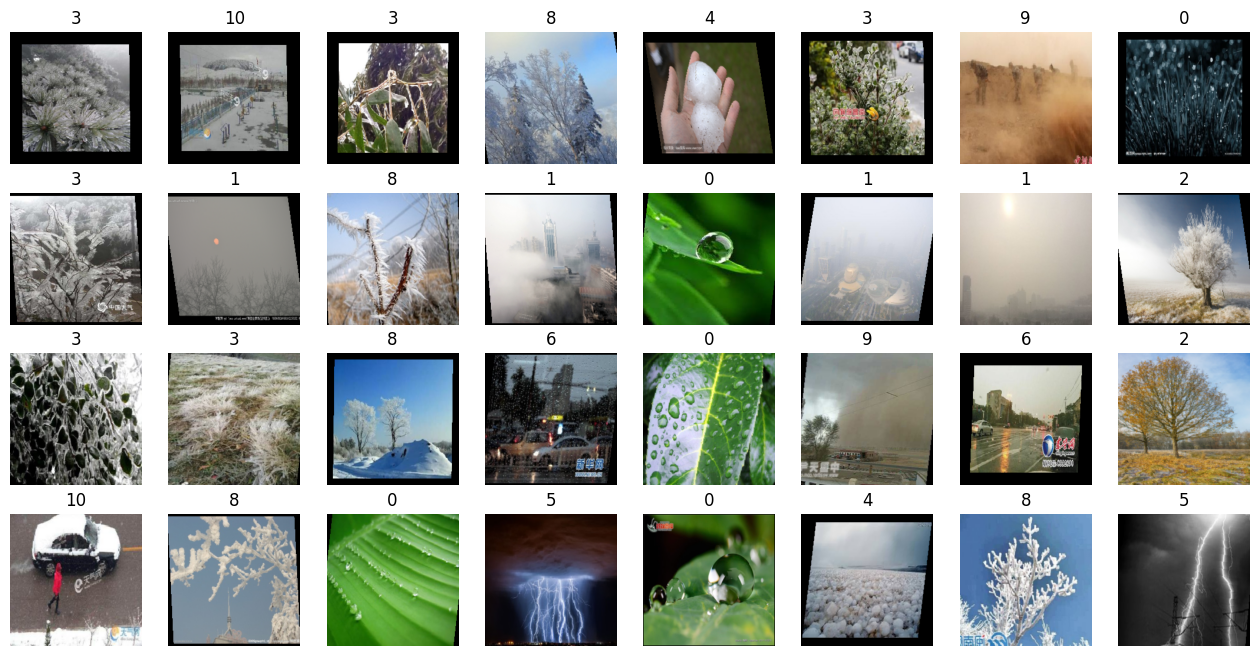

In [13]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label.item())
    ax.axis('off')

# 2. 학습

## 2-1 모델 선정

#### MobileNet
MobileNet은 경량화된 딥러닝 모델로, 모바일 기기와 임베디드 시스템에서 사용하기에 적합한 모델입니다. PyTorch에서는 torchvision 라이브러리를 통해 MobileNet을 쉽게 사용할 수 있습니다. 아래는 MobileNetV2를 예로 들어, PyTorch에서 MobileNet을 사용하는 간단한 예제 코드입니다.


In [14]:
model = models.mobilenet_v2(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]


In [15]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [25]:
for param in model.parameters():
    param.requires_grad = False

# model.classifier = nn.Sequential(
#     nn.Linear(1280, 512),
#     nn.ReLU(),
#     nn.Linear(512, 11)
# ).to(device)
# train     : Epoch   11/10 Loss: 0.3206 Accuracy:  89.05%
# validation: Epoch   11/10 Loss: 0.3923 Accuracy:  87.24%

model.classifier = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Sigmoid(),
    nn.Linear(128, 11)
).to(device)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [26]:
# 학습
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 10

for epoch in  range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)

            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')


train     : Epoch    1/10 Loss: 1.1311 Accuracy:  66.66%
validation: Epoch    1/10 Loss: 0.6306 Accuracy:  82.52%
train     : Epoch    2/10 Loss: 0.5739 Accuracy:  81.72%
validation: Epoch    2/10 Loss: 0.5326 Accuracy:  82.16%
train     : Epoch    3/10 Loss: 0.4831 Accuracy:  84.07%
validation: Epoch    3/10 Loss: 0.5105 Accuracy:  81.85%
train     : Epoch    4/10 Loss: 0.4460 Accuracy:  85.01%
validation: Epoch    4/10 Loss: 0.4603 Accuracy:  83.78%
train     : Epoch    5/10 Loss: 0.4196 Accuracy:  85.35%
validation: Epoch    5/10 Loss: 0.5062 Accuracy:  82.87%
train     : Epoch    6/10 Loss: 0.3934 Accuracy:  86.56%
validation: Epoch    6/10 Loss: 0.3942 Accuracy:  86.85%
train     : Epoch    7/10 Loss: 0.3578 Accuracy:  87.56%
validation: Epoch    7/10 Loss: 0.4483 Accuracy:  85.25%
train     : Epoch    8/10 Loss: 0.3729 Accuracy:  87.01%
validation: Epoch    8/10 Loss: 0.4323 Accuracy:  85.07%
train     : Epoch    9/10 Loss: 0.3455 Accuracy:  87.37%
validation: Epoch    9/10 Loss:

In [27]:
torch.save(model.state_dict(),'model.pth') # model.h5 (텐서플로우)

In [28]:
# 학습
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 10

for epoch in  range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)

            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')


train     : Epoch    1/10 Loss: 0.3316 Accuracy:  88.75%
validation: Epoch    1/10 Loss: 0.4237 Accuracy:  85.61%
train     : Epoch    2/10 Loss: 0.3051 Accuracy:  89.75%
validation: Epoch    2/10 Loss: 0.3666 Accuracy:  87.38%
train     : Epoch    3/10 Loss: 0.2829 Accuracy:  90.15%
validation: Epoch    3/10 Loss: 0.4019 Accuracy:  86.80%
train     : Epoch    4/10 Loss: 0.2698 Accuracy:  90.16%
validation: Epoch    4/10 Loss: 0.4400 Accuracy:  85.67%
train     : Epoch    5/10 Loss: 0.2768 Accuracy:  90.07%
validation: Epoch    5/10 Loss: 0.3886 Accuracy:  87.50%
train     : Epoch    6/10 Loss: 0.2593 Accuracy:  90.91%
validation: Epoch    6/10 Loss: 0.4186 Accuracy:  86.63%
train     : Epoch    7/10 Loss: 0.2599 Accuracy:  90.91%
validation: Epoch    7/10 Loss: 0.4335 Accuracy:  85.76%
train     : Epoch    8/10 Loss: 0.2480 Accuracy:  91.19%
validation: Epoch    8/10 Loss: 0.4330 Accuracy:  86.07%
train     : Epoch    9/10 Loss: 0.2600 Accuracy:  90.82%
validation: Epoch    9/10 Loss:

In [29]:
torch.save(model.state_dict(),'model_2.pth') # model.h5 (텐서플로우)

In [30]:
for epoch in  range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)

            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')


train     : Epoch    1/10 Loss: 0.2255 Accuracy:  92.11%
validation: Epoch    1/10 Loss: 0.3885 Accuracy:  87.94%
train     : Epoch    2/10 Loss: 0.2199 Accuracy:  91.91%
validation: Epoch    2/10 Loss: 0.3840 Accuracy:  87.42%
train     : Epoch    3/10 Loss: 0.2057 Accuracy:  92.68%
validation: Epoch    3/10 Loss: 0.3627 Accuracy:  88.25%
train     : Epoch    4/10 Loss: 0.1782 Accuracy:  93.67%
validation: Epoch    4/10 Loss: 0.4140 Accuracy:  87.27%
train     : Epoch    5/10 Loss: 0.2072 Accuracy:  92.53%
validation: Epoch    5/10 Loss: 0.3777 Accuracy:  88.44%
train     : Epoch    6/10 Loss: 0.2060 Accuracy:  92.61%
validation: Epoch    6/10 Loss: 0.3696 Accuracy:  87.98%
train     : Epoch    7/10 Loss: 0.1843 Accuracy:  93.54%
validation: Epoch    7/10 Loss: 0.4412 Accuracy:  86.18%
train     : Epoch    8/10 Loss: 0.1758 Accuracy:  93.86%
validation: Epoch    8/10 Loss: 0.3899 Accuracy:  87.45%
train     : Epoch    9/10 Loss: 0.1772 Accuracy:  93.44%
validation: Epoch    9/10 Loss:

In [31]:
torch.save(model.state_dict(),'model_3.pth') # model.h5 (텐서플로우)

In [32]:
for epoch in  range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)

            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')


train     : Epoch    1/10 Loss: 0.1687 Accuracy:  93.75%
validation: Epoch    1/10 Loss: 0.4150 Accuracy:  88.25%
train     : Epoch    2/10 Loss: 0.1601 Accuracy:  94.65%
validation: Epoch    2/10 Loss: 0.4017 Accuracy:  88.27%
train     : Epoch    3/10 Loss: 0.1565 Accuracy:  94.30%
validation: Epoch    3/10 Loss: 0.4400 Accuracy:  87.20%
train     : Epoch    4/10 Loss: 0.1549 Accuracy:  94.13%
validation: Epoch    4/10 Loss: 0.3849 Accuracy:  88.98%
train     : Epoch    5/10 Loss: 0.1491 Accuracy:  94.69%
validation: Epoch    5/10 Loss: 0.4067 Accuracy:  87.56%
train     : Epoch    6/10 Loss: 0.1421 Accuracy:  94.83%
validation: Epoch    6/10 Loss: 0.4156 Accuracy:  87.54%
train     : Epoch    7/10 Loss: 0.1349 Accuracy:  95.41%
validation: Epoch    7/10 Loss: 0.4105 Accuracy:  87.76%
train     : Epoch    8/10 Loss: 0.1374 Accuracy:  95.19%
validation: Epoch    8/10 Loss: 0.4179 Accuracy:  87.44%
train     : Epoch    9/10 Loss: 0.1344 Accuracy:  95.41%
validation: Epoch    9/10 Loss:

In [33]:
torch.save(model.state_dict(),'model_4.pth') # model.h5 (텐서플로우)

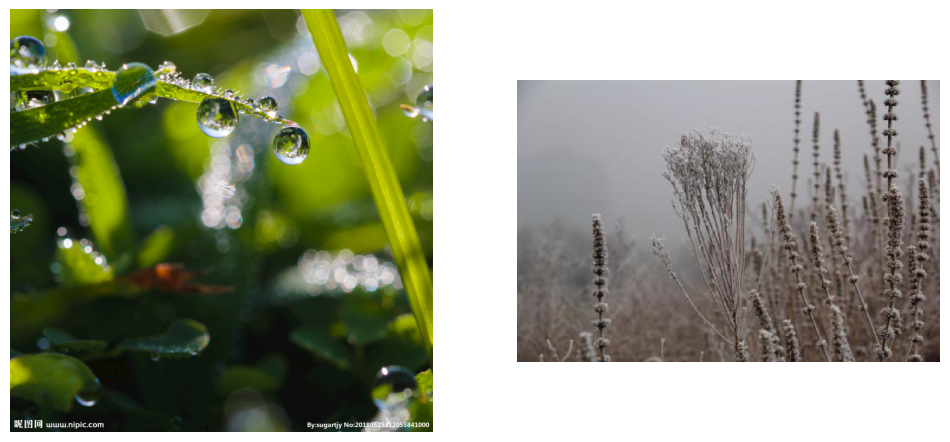

In [34]:
# 테스트
from PIL import Image
img1 = Image.open('./validation/dew/2264.jpg')
img2 = Image.open('./validation/frost/3676.jpg')

fig, axes = plt.subplots(1,  2, figsize=(12,  6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [36]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [37]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [38]:
y_pred = model(test_batch)
y_pred

tensor([[ 6.3339, -5.8101, -3.6279, -0.5687, -1.2340, -5.3171, -4.0540, -5.7710,
         -6.2392, -7.3888, -4.8153],
        [-3.2140, -2.8937,  0.7567, -0.4881, -7.5838, -4.9791, -4.8143, -9.8276,
         -0.0244, -0.0682, -3.0404]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [39]:
# 강사님 코드
y_prob = nn.Softmax(1)(y_pred)
probs, idx = torch.topk(y_prob, k=3)

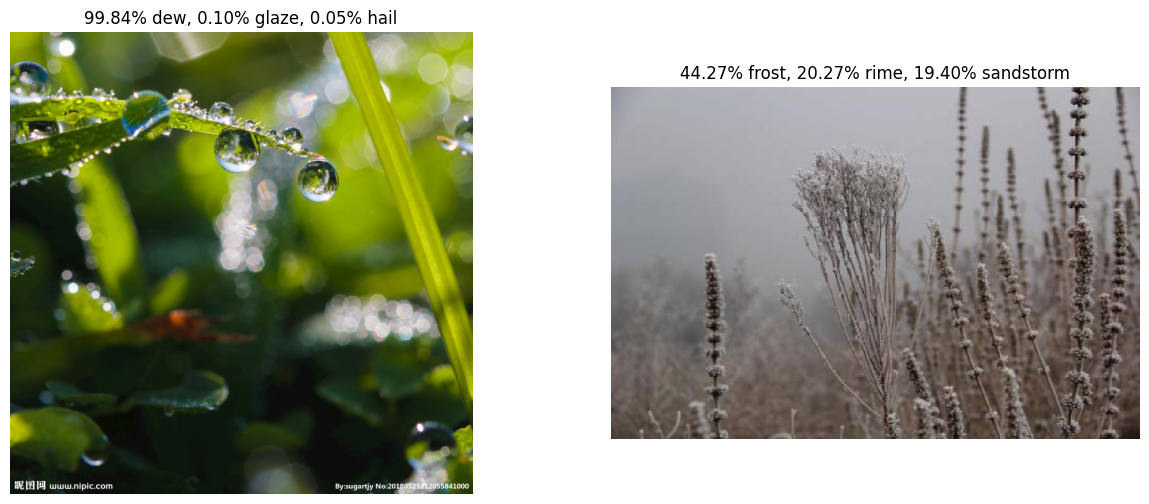

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[0, 0] * 100,
    image_datasets['validation'].classes[idx[0, 0]],
    probs[0, 1] * 100,
    image_datasets['validation'].classes[idx[0, 1]],
    probs[0, 2] * 100,
    image_datasets['validation'].classes[idx[0, 2]],
))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[1, 0] * 100,
    image_datasets['validation'].classes[idx[1, 0]],
    probs[1, 1] * 100,
    image_datasets['validation'].classes[idx[1, 1]],
    probs[1, 2] * 100,
    image_datasets['validation'].classes[idx[1, 2]],
))
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()